In [1]:
!pip uninstall -y med_metrics
!pip install -e ..

Found existing installation: med-metrics 0.0.2
Uninstalling med-metrics-0.0.2:
  Successfully uninstalled med-metrics-0.0.2
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/jovyan/Documents/workspace/med_metrics
  Preparing metadata (setup.py) ... done
  Running setup.py develop for med-metrics


In [2]:
from med_metrics.bootstrap import bootstrap_evaluation, analyze_bootstrap_results, summarize_bootstrap_results, plot_bootstrap_curve
from med_metrics.metrics import average_NNTvsTreated, average_net_benefit
from med_metrics.curves import NNTvsTreated_curve, net_benefit_curve
from med_metrics.compatibility_metrics import backwards_trust_compatibility, backwards_error_compatibility, rank_based_compatibility
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

# Generate Data

In [3]:
n = 1000
rng = np.random.default_rng(41)
p = rng.uniform(0,1,n)
q = np.random.uniform(0,1,n)
y_true = rng.binomial(1, p)

y_model_0 = p*q
y_model_1 = p

# Curve & Compatibility Metric Examples

## NNT vs Number Treated

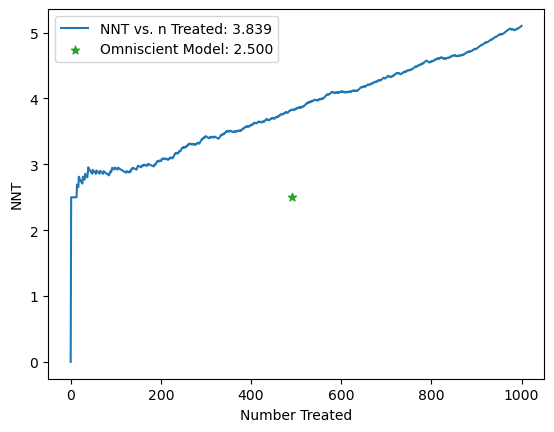

In [4]:
rho = 0.4 #relative risk reduction
n_pos = sum(y_true)
perfect_NNT = 1/rho

mean_NNTvsTreated = average_NNTvsTreated(y_true, y_model_0, rho=rho)
treated, NNT, thresholds = NNTvsTreated_curve(y_true, y_model_0, rho=rho)

plt.plot(treated, NNT, color='tab:blue', 
         label='NNT vs. n Treated: {0:.3f}'.format(mean_NNTvsTreated))
plt.scatter(n_pos, perfect_NNT, color='tab:green', marker='*', 
            label='Omniscient Model: {0:.3f}'.format(perfect_NNT))
plt.legend()
plt.xlabel('Number Treated')
plt.ylabel('NNT')
plt.show()

## Net Benefit Curve

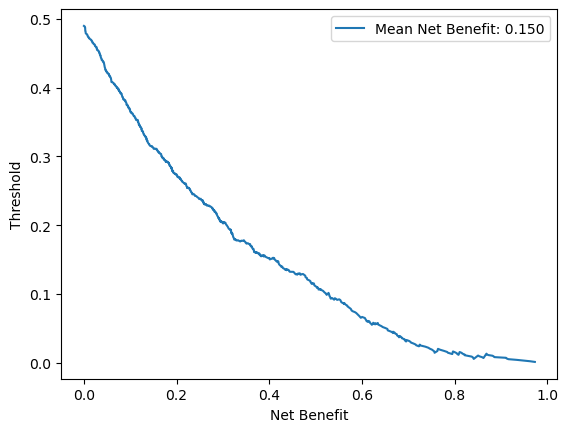

In [5]:
mean_nb = average_net_benefit(y_true, y_model_0)
thresholds, net_benefit_scores, _ = net_benefit_curve(y_true, y_model_0)

plt.plot(thresholds, net_benefit_scores, color='tab:blue', 
         label='Mean Net Benefit: {0:.3f}'.format(mean_nb))
plt.legend()
plt.xlabel('Net Benefit')
plt.ylabel('Threshold')
plt.show()

## Compatibility Metrics

In [6]:
btc = backwards_trust_compatibility(y_true, y_model_0>0.5, y_model_1>0.5)
print('Backwards Trust Compatibility: {0:.3f}'.format(btc))

rbc = rank_based_compatibility(y_true, y_model_0, y_model_1)
print('Rank-based Compatibility: {0:.3f}'.format(rbc))

Backwards Trust Compatibility: 0.823
Rank-based Compatibility: 0.920


# Bootstrapping Example

## Set up

In [7]:
metric_funcs = {'roc_auc_score': roc_auc_score, 
                'mean_NNTvsTreated': average_NNTvsTreated,
                'mean_NNTvsTreated_10to30PercentTreated': average_NNTvsTreated,
                'mean_net_benefit': average_net_benefit,
                'mean_net_benefit_0to25PercentThreshold': average_net_benefit
               }

metric_funcs_kwargs = {'mean_NNTvsTreated': {'rho':0.4},
                       'mean_NNTvsTreated_10to30PercentTreated': {'rho':0.4, 
                                                                     'min_treated': n*0.1,
                                                                     'max_treated': n*0.3},
                       'mean_net_benefit_0to25PercentThreshold': {'max_threshold': 0.25},
                      }

curve_funcs = {'roc_curve': roc_curve, 
               'NNTvsT': NNTvsTreated_curve,
               'NNTvsT_10to30PercentTreated': NNTvsTreated_curve,
               'net_benefit_curve': net_benefit_curve,
               'net_benefit_curve_0to25PercentThreshold': net_benefit_curve,
              }

curve_funcs_kwargs = {'NNTvsT': {'rho':0.4},
                      'NNTvsT_10to30PercentTreated': {'rho':0.4, 
                                               'min_treated': n*0.1,
                                               'max_treated': n*0.3},
                      'net_benefit_curve_0to25PercentThreshold': {'max_threshold': 0.25},
                     }

## Perform the bootstrap analysis

In [8]:
bootstrapped_results = bootstrap_evaluation(
    y_true=y_true,
    y_scores={'model_0': y_model_0},
    metric_funcs=metric_funcs,
    curve_funcs=curve_funcs,
    n_bootstraps=1000,
    random_state=42,
    metric_funcs_kwargs=metric_funcs_kwargs,
    curve_funcs_kwargs=curve_funcs_kwargs
)

## Summarize Bootstrap Analysis

In [9]:
mf_summary_results, _ = summarize_bootstrap_results(bootstrapped_results)
display(pd.DataFrame(mf_summary_results))

,roc_auc_score,mean_NNTvsTreated,mean_NNTvsTreated_10to30PercentTreated,mean_net_benefit,mean_net_benefit_0to25PercentThreshold
model_0,"0.723 (0.692, 0.756)","3.839 (3.61, 4.045)","3.092 (2.87, 3.264)","0.15 (0.13, 0.167)","0.349 (0.317, 0.378)"


## Display Bootstrap Curve Results

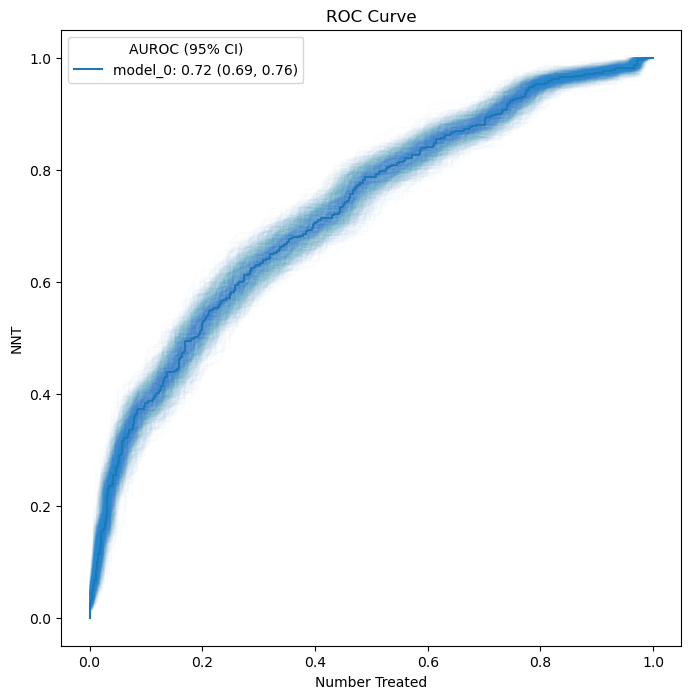

In [10]:
_ = plot_bootstrap_curve(bootstrapped_results, 'roc_auc_score', 'roc_curve',
                     xlabel='Number Treated', ylabel='NNT', 
                     title='ROC Curve', legend_title='AUROC')

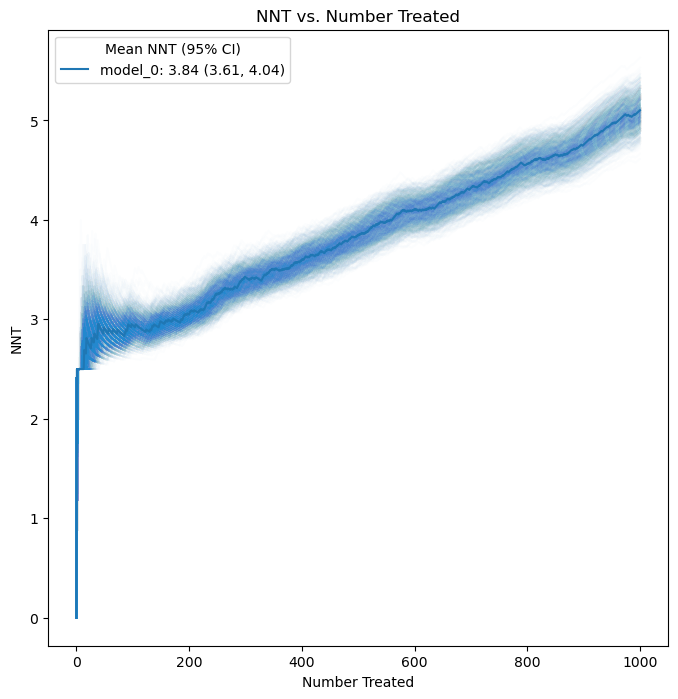

In [11]:
_ = plot_bootstrap_curve(bootstrapped_results, 'mean_NNTvsTreated', 'NNTvsT',
                     xlabel='Number Treated', ylabel='NNT', 
                     title='NNT vs. Number Treated', legend_title='Mean NNT', )

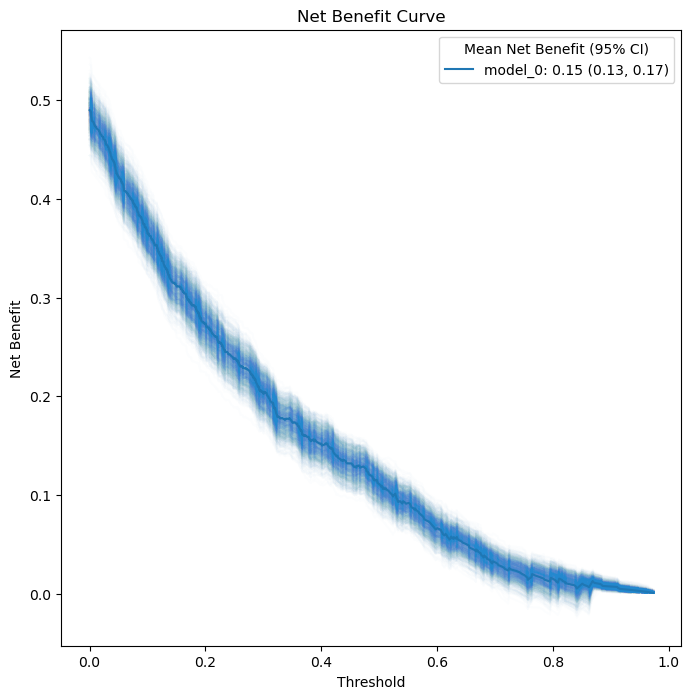

In [12]:
_ = plot_bootstrap_curve(bootstrapped_results, 'mean_net_benefit', 'net_benefit_curve',
                     xlabel='Threshold', ylabel='Net Benefit', 
                     title='Net Benefit Curve', legend_title='Mean Net Benefit')

# Model Comparison

## Perform the bootstrap analysis with dictionary of model scores

In [13]:
# Perform the bootstrap analysis
y_scores = {'model_0': p*q,
            'model_1': p}

bootstrapped_results = bootstrap_evaluation(
    y_true=y_true,
    y_scores=y_scores,
    metric_funcs=metric_funcs,
    curve_funcs=curve_funcs,
    compatibility_metric_funcs=rank_based_compatibility,
    n_bootstraps=1000,
    random_state=42,
    metric_funcs_kwargs=metric_funcs_kwargs,
    curve_funcs_kwargs=curve_funcs_kwargs
)

## Summarize Bootstrap Analysis

In [14]:
mf_summary_results, cmf_summary_results = summarize_bootstrap_results(bootstrapped_results)
display(pd.DataFrame(mf_summary_results))
display(pd.DataFrame(cmf_summary_results))

,roc_auc_score,mean_NNTvsTreated,mean_NNTvsTreated_10to30PercentTreated,mean_net_benefit,mean_net_benefit_0to25PercentThreshold
model_0,"0.723 (0.692, 0.756)","3.839 (3.61, 4.045)","3.092 (2.87, 3.264)","0.15 (0.13, 0.167)","0.349 (0.317, 0.378)"
model_1,"0.841 (0.818, 0.867)","3.503 (3.323, 3.648)","2.852 (2.7, 2.972)","0.241 (0.212, 0.273)","0.431 (0.396, 0.465)"


,,rank_based_compatibility
model_0,model_1,"0.92 (0.904, 0.938)"
model_1,model_0,"0.791 (0.763, 0.819)"


## Display Boostrap Curve Results

Also highlight some of the functionality associated with plotting bootstrap curves

### Display Default Bootstrap Curve - ROC

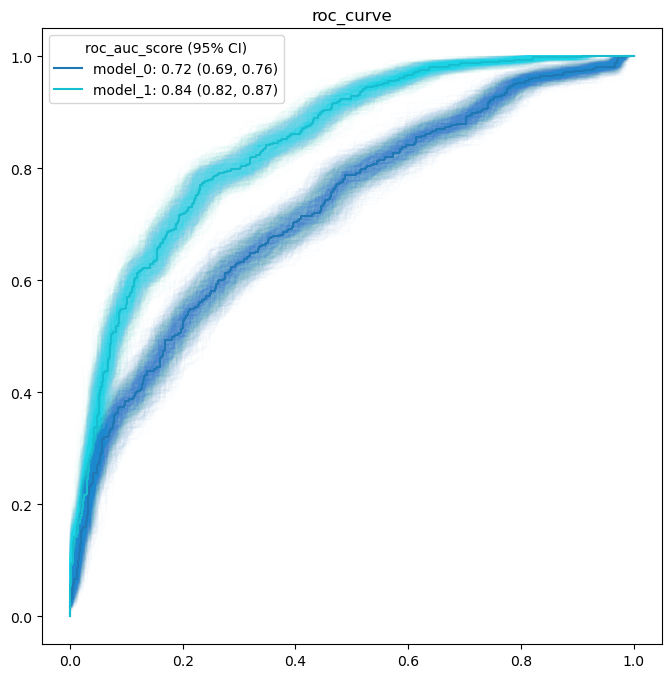

In [15]:
_ = plot_bootstrap_curve(bootstrapped_results, 'roc_auc_score', 'roc_curve')

### Display Bootstrap Curve Using Options - NNT vs. Number Treated

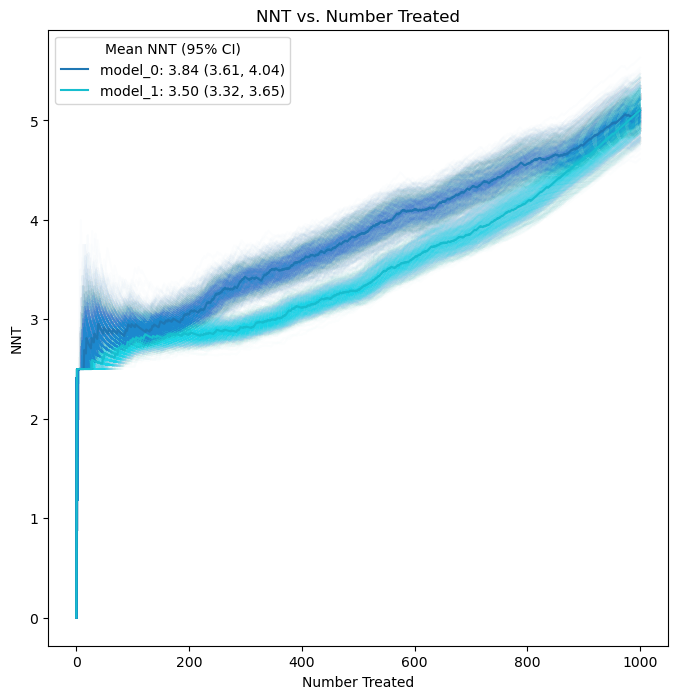

In [16]:
_ = plot_bootstrap_curve(bootstrapped_results, 'mean_NNTvsTreated', 'NNTvsT',
                         xlabel='Number Treated', ylabel='NNT', 
                         title='NNT vs. Number Treated', legend_title='Mean NNT',)

### Get Bootstrap Curve Using Options & Modify Figure

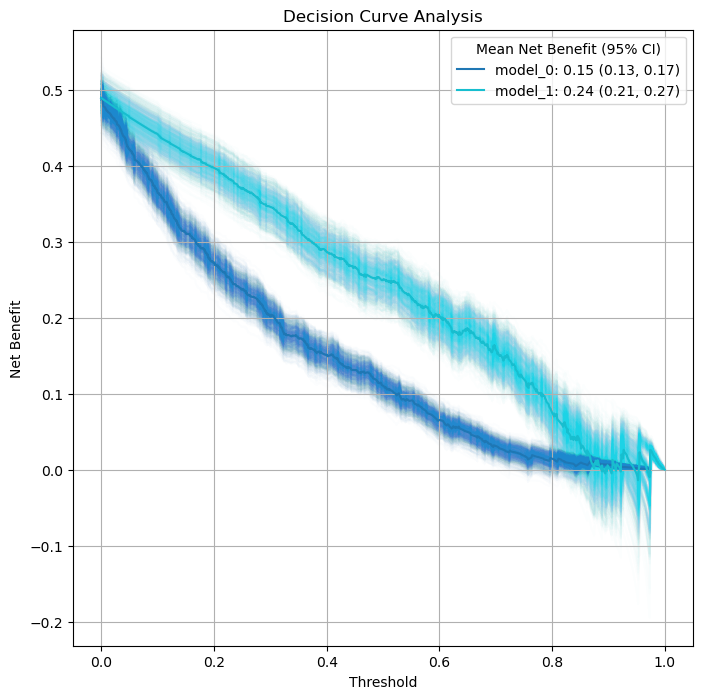

In [17]:
fig, ax  = plot_bootstrap_curve(bootstrapped_results, 'mean_net_benefit', 'net_benefit_curve',
                                xlabel='Threshold', ylabel='Net Benefit', 
                                title='Net Benefit Curve', legend_title='Mean Net Benefit',
                                show_plot=False)
# Customizations by the user
ax.set_title("Decision Curve Analysis")
ax.grid(True)
# Display the plot
plt.show()

# Curves and Metrics Can Be Range Restricted

## NNT Where Number Treated is Between 10% and 30%

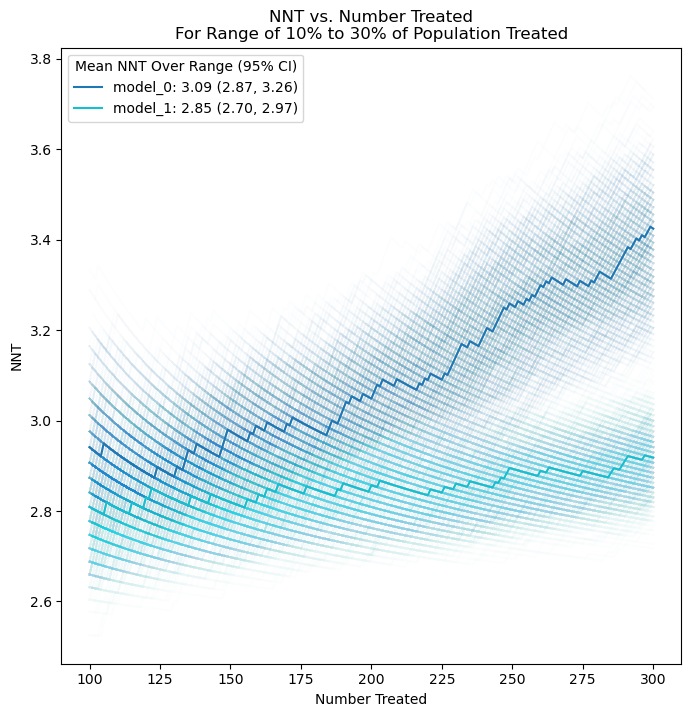

In [18]:
_ = plot_bootstrap_curve(bootstrapped_results, 
                         'mean_NNTvsTreated_10to30PercentTreated', 'NNTvsT_10to30PercentTreated',
                         xlabel='Number Treated', ylabel='NNT', 
                         title='NNT vs. Number Treated\nFor Range of 10% to 30% of Population Treated', 
                         legend_title='Mean NNT Over Range',)

## Net Benefit Where Threshold is Less Than 25%

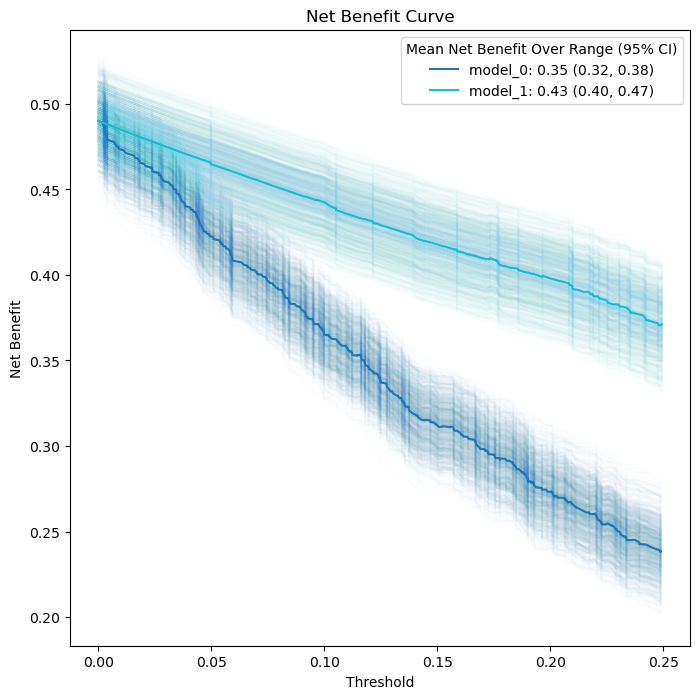

In [19]:
_ = plot_bootstrap_curve(bootstrapped_results, 
                         'mean_net_benefit_0to25PercentThreshold', 'net_benefit_curve_0to25PercentThreshold',
                         xlabel='Threshold', ylabel='Net Benefit', 
                         title='Net Benefit Curve', legend_title='Mean Net Benefit Over Range',
                         show_plot=False)